# Connect and authorize google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


# Libraries

In [ ]:
import os
import sys
import pickle

import time
import math
import copy

import wget

import numpy as np
import pandas as pd

from scipy.stats import binned_statistic_2d
from scipy import stats

from astropy.io import fits
from astropy.wcs import WCS
from astropy    import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, join
import astropy.constants as const

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

from scipy.signal import savgol_filter, convolve, windows

import torch

from pathlib import Path

from spectral_cube import SpectralCube

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# Paths

In [ ]:
gaia_path = Path('/content/gdrive/MyDrive/Colab Notebooks/gaia/')
ml_path = Path('/content/gdrive/MyDrive/Colab Notebooks/ML')
gaskap_path = Path('/content/gdrive/MyDrive/Colab Notebooks/GASKAP')

ml_data_path = ml_path / 'data'
data_path = gaia_path / 'data'
dust_data_path = data_path / 'edenhofer'
dust3d_data_path = data_path / 'dust3d'
dust3d_spectra_path = dust3d_data_path / 'spectra'

gaskap_data_path = gaskap_path / 'data'

local_bubble_data_path = data_path / 'oneill'

gaskap_hires_data_path = gaskap_data_path / 'hires'
gaskap_hires_result_path = gaskap_hires_data_path / 'results'



GASS_data_path = ml_data_path / 'GASS'
hi_dust_data_file = dust3d_data_path / 'hi_dust_distances_full.npz'

dynamics_file = data_path / 'galah_dr4_vac_dynamics_240705.fits'
allstar_file = data_path / 'galah_dr4_allstar_240705.fits'
gaia_catalog_file = data_path / 'stellar_params_catalog-1kpc.fits'
gaia_catalog_file = data_path / 'stars_MC_fg.fits'

# Fcn

In [ ]:
vlsr_sun = 15.17 # km/s, see Sven's paper GALAH DR4 https://arxiv.org/pdf/2409.19858 Section 7.2.2


# Create velocity range around the central velocity
velocity_range = np.linspace(-100., 100., 500)

# Define the Gaussian function
def gaussian(x, amp, center, std):
    return amp * np.exp(-(x - center)**2 / (2 * std**2))

In [ ]:
def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def download_galah_data(save_path, sobject_id):
    sobject_id = str(sobject_id)
    output_star_id_file = save_path / f'{sobject_id}_allstar_fit_spectrum.fits'
    # print(output_star_id_file)
    save_path = str(save_path)

    if not os.path.exists(output_star_id_file):
        url = f'https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/analysis_products_allstar/{sobject_id[:6]}/{sobject_id}/{sobject_id}_allstar_fit_spectrum.fits'
        wget.download(url, out=save_path)

        url = f'https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/analysis_products_allstar/{sobject_id[:6]}/{sobject_id}/{sobject_id}_allstar_fit_comparison.pdf'
        wget.download(url, out=save_path)

In [ ]:
def wavelength_to_rv(wavelength_obs, wavelength_rest):
    """
    Calculate radial velocity from observed and rest wavelengths using the
    relativistic Doppler formula.

    Parameters:
    -----------
    wavelength_obs : float or array-like
        Observed wavelength(s) in Angstroms
    wavelength_rest : float
        Rest wavelength in Angstroms

    Returns:
    --------
    float or array-like
        Radial velocity in km/s (positive values indicate redshift/receding motion)
    """
    # Convert wavelengths to float if they're strings
    wavelength_obs = np.float64(wavelength_obs)
    wavelength_rest = np.float64(wavelength_rest)

    # Calculate velocity using relativistic formula
    c = const.c.to('km/s').value  # speed of light in km/s

    # (λ_obs / λ_rest)^2 = (1 + v/c)/(1 - v/c)
    # Solving for v:
    z = wavelength_obs / wavelength_rest
    rv = c * (z**2 - 1) / (z**2 + 1)

    return rv

def wavelength_to_rv_simple(wavelength_obs, wavelength_rest):
    """
    Calculate radial velocity using the simple (non-relativistic) Doppler formula.
    Use this only for v << c.

    Parameters:
    -----------
    wavelength_obs : float or array-like
        Observed wavelength(s) in Angstroms
    wavelength_rest : float
        Rest wavelength in Angstroms

    Returns:
    --------
    float or array-like
        Radial velocity in km/s (positive values indicate redshift/receding motion)
    """
    c = const.c.to('km/s').value  # speed of light in km/s

    # Simple Doppler formula: v/c = Δλ/λ
    # rv = c * (wavelength_obs - wavelength_rest) / wavelength_rest
    rv = c * (wavelength_obs - wavelength_rest) / wavelength_obs

    return rv

In [ ]:
def wavelength_to_vlsrk(observed_wavelengths, rest_wavelength, galactic_l, galactic_b, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25):
    """
    Converts observed wavelengths to VLSRK (velocity relative to the LSR) using the radio convention.

    Args:
        observed_wavelengths (array-like): Array of observed wavelengths (in Angstroms or nanometers).
        rest_wavelength (float): Rest wavelength of the spectral line (in the same units as observed_wavelengths).
        galactic_l (float): Galactic longitude (in degrees).
        galactic_b (float): Galactic latitude (in degrees).
        u_lsr (float, optional): LSR velocity component towards the Galactic Center (km/s).
        v_lsr (float, optional): LSR velocity component in the direction of Galactic rotation (km/s).
        w_lsr (float, optional): LSR velocity component perpendicular to the Galactic plane (km/s).

    Returns:
        numpy.ndarray: Array of VLSRK velocities (in km/s).
    """

    c = const.c.to('km/s').value  # Speed of light in km/s

    observed_wavelengths = np.array(observed_wavelengths)

    # 1. Radial Velocity (Vrad) using radio convention
    vrad = c * (1 - rest_wavelength / observed_wavelengths)

    # 2. Heliocentric Velocity (Vhelio)
    # This requires more information about the observation time and location,
    # and the earth's velocity. For simplicity, we are skipping this part.
    # In practice, you would use astropy.coordinates.EarthLocation and astropy.time.Time,
    # to accurately get the earth's velocity.
    # For now, we are assuming Vhelio = Vrad. Therefore, the result will be slightly off.
    vhelio = vrad

    # 3. VLSRK
    l_rad = np.radians(galactic_l)
    b_rad = np.radians(galactic_b)

    vlsrk = vhelio + u_lsr * np.cos(b_rad) * np.cos(l_rad) + v_lsr * np.cos(b_rad) * np.sin(l_rad) + w_lsr * np.sin(b_rad)

    return vlsrk


# vlsrk_velocities = wavelength_to_vlsrk(observed_wavelengths_angstroms, rest_wavelength_angstroms, galactic_l, galactic_b)

In [ ]:
def wavelength_to_vlsrk_with_galah_correction(observed_wavelengths, rest_wavelength, galactic_l, galactic_b, rv_comp_1, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25):
    """
    Converts observed wavelengths to VLSRK (velocity relative to the LSR) using the radio convention.

    Args:
        observed_wavelengths (array-like): Array of observed wavelengths (in Angstroms or nanometers).
        rest_wavelength (float): Rest wavelength of the spectral line (in the same units as observed_wavelengths).
        galactic_l (float): Galactic longitude (in degrees).
        galactic_b (float): Galactic latitude (in degrees).
        galah_allstar['rv_comp_1']: See GALAH
        u_lsr (float, optional): LSR velocity component towards the Galactic Center (km/s).
        v_lsr (float, optional): LSR velocity component in the direction of Galactic rotation (km/s).
        w_lsr (float, optional): LSR velocity component perpendicular to the Galactic plane (km/s).

    Returns:
        numpy.ndarray: Array of VLSRK velocities (in km/s).
    """

    c = const.c.to('km/s').value  # Speed of light in km/s

    observed_wavelengths = np.array(observed_wavelengths)

    # 1. Radial Velocity (Vrad) using radio convention
    vrad = c * (1 - rest_wavelength / observed_wavelengths) + rv_comp_1
    # vrad = c * (1 - rest_wavelength / observed_wavelengths)

    # 2. Heliocentric Velocity (Vhelio)
    # This requires more information about the observation time and location,
    # and the earth's velocity. For simplicity, we are skipping this part.
    # In practice, you would use astropy.coordinates.EarthLocation and astropy.time.Time,
    # to accurately get the earth's velocity.
    # For now, we are assuming Vhelio = Vrad. Therefore, the result will be slightly off.
    vhelio = vrad

    # 3. VLSRK
    l_rad = np.radians(galactic_l)
    b_rad = np.radians(galactic_b)

    vlsrk = vhelio + u_lsr * np.cos(b_rad) * np.cos(l_rad) + v_lsr * np.cos(b_rad) * np.sin(l_rad) + w_lsr * np.sin(b_rad)

    return vlsrk


# vlsrk_velocities = wavelength_to_vlsrk(observed_wavelengths_angstroms, rest_wavelength_angstroms, galactic_l, galactic_b)

In [ ]:
# Define the Gaussian function with FWHM
def gaussian(x, A, x0, FWHM):
    sigma = FWHM / 2.3548
    return A * np.exp(-(x-x0)**2 / (2*sigma**2))

In [ ]:
def compute_column_density_KI(W_lambda_angstrom):
    """
    Compute the column density for weak lines:

    \[
    W_{\lambda} = \frac{\pi e^2}{m_e c^2} f \lambda^2 N
    \]

    Where:

    - \( e \) is the electron charge
    - \( m_e \) is the electron mass
    - \( c \) is the speed of light
    - \( f \) is the oscillator strength of the transition
    - \( \lambda \) is the wavelength of the line

    """
    # f = 0.3393  # Oscillator strength
    f = 0.332 # Oscillator strength
    lambda_ = 7698.9643 * u.Angstrom  # Wavelength in Angstrom lambda_rest = 7698.9643 # Angstroms

    # Convert equivalent width from Angstrom to meters
    W_lambda_m = (W_lambda_angstrom * u.Angstrom).to(u.m)

    # Compute column density using the formula
    N = (W_lambda_m * const.m_e * const.c**2) / (np.pi * const.e.gauss**2 * f * lambda_.to(u.m)**2)

    return N.to(10**(10)/u.cm**2)  # This ensures the column density is returned in SI units (m^-2)

<>:5: SyntaxWarning: invalid escape sequence '\['
<>:5: SyntaxWarning: invalid escape sequence '\['
/tmp/ipython-input-2010699875.py:5: SyntaxWarning: invalid escape sequence '\['
  \[


# For plotting

In [ ]:

# Circle
def _circle(x, y, r):
    theta = np.linspace(0, 2*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

gl_LMC = 279.
gb_LMC = -33.5
R_LMC = 5.

gl_SMC = 302.
gb_SMC = -44.5
R_SMC = 3.

LMC = dict(
    gl = gl_LMC,
    gb = gb_LMC,
    center = [gl_LMC, gb_LMC],
    glon_range = [270., 307.],
    glat_range = [-48., -25.],
    circ = _circle(gl_LMC, gb_LMC, R_LMC),
    name = 'Large Magellanic Cloud'
)


SMC = dict(
    gl = gl_SMC,
    gb = gb_SMC,
    center = [gl_SMC, gb_SMC],
    glon_range = [295., 315.],
    glat_range = [-50., -40.],
    circ = _circle(gl_SMC, gb_SMC, R_SMC),
    name = 'Small Magellanic Cloud'
)


# Approximate locations of LMC and SMC
SMC_xcirc, SMC_ycirc = SMC['circ']
LMC_xcirc, LMC_ycirc = LMC['circ']

# Circle
def hcircle(x, y, r):
    theta = np.linspace(1.365*np.pi, 1.55*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

# Circle
def vcircle(x, y, r):
    theta = np.linspace(1.73*np.pi, 1.87*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

gl_ch = 295.
gb_ch = 21.8
R_ch = 59.

gl_cv = 238.
gb_cv = -5.
R_cv = 57.


ch_xcirc, ch_ycirc = hcircle(gl_ch, gb_ch, R_ch)
cv_xcirc, cv_ycirc = vcircle(gl_cv, gb_cv, R_cv)

lmc_glon = [270., 308.]
lmc_glat = [-48.99, -26.45]

gl_boundary = np.array([297., 302., 305., 308., 305., 297., 298., 295., 292., 294., 285., 283.5, 271.5, 271., 288.5, 290., 295., 297.])
gb_boundary = np.array([-36., -35., -40., -42.5, -48.5, -46.2, -43., -38.25, -39.8, -44.5, -45.9, -40.8, -41.5, -29., -26.9, -32., -31., -36.])

# Read GASKAP-HI absorption measurements: Pilot II data (all)

In [ ]:
hi_abs_all_filename = gaskap_hires_data_path / 'absdr3' / 'gaskap_abs_spectra_dr3b.csv'
print(hi_abs_all_filename)

abs_df = pd.read_csv(hi_abs_all_filename)
nmes, _ = abs_df.shape
print(f'Number of all sources {nmes}')
abs_df.head(5)

In [ ]:
non_hiabs_df = abs_df[abs_df.mw_detection == False]
non_hiabs_df

,id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,...,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids,sbid,mw_detection,saturated
2,9,J011056-731406,SB30665_component_3b,17.735945,-73.235151,300.984436,-43.819266,A,115.037003,208.171005,...,5.745,39.880001,4.874624e+21,False,-0.000363,M344-11,30665,30665,False,False
8,24,J004327-704135,SB30665_component_11a,10.863942,-70.693260,303.888848,-46.420157,B,215.136993,332.138000,...,5.895,131.210007,2.227711e+20,False,0.000643,M344-11,30665,30665,False,False
10,26,J013229-723956,SB30665_component_12a,23.123198,-72.665757,298.690805,-44.122841,B,138.602005,138.981995,...,4.800,127.029999,1.083733e+21,False,0.002100,M344-06,30665,30665,False,False
11,28,J002919-754018,SB30665_component_13a,7.330447,-75.671738,304.752927,-41.378221,B,185.477005,206.205994,...,4.860,7.050000,1.705849e+20,False,0.002592,M344-11,30665,30665,False,False
12,29,J002920-754008,SB30665_component_13b,7.334793,-75.668999,304.751919,-41.381065,B,70.438004,70.567001,...,4.735,156.479996,1.705849e+20,False,0.000732,M344-11,30665,30665,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2709,0,J045631-762533,SB38845_component_245a,74.132371,-76.425960,288.737278,-32.932020,C,18.582001,20.014000,...,4.195,40.980000,0.000000e+00,False,-0.001994,M000-02,"38509,38845",38845,False,False
2710,0,J045907-753153,SB38845_component_261a,74.779860,-75.531478,287.674258,-33.105855,C,17.294001,21.070000,...,4.570,51.529999,0.000000e+00,False,-0.000745,M000-02,"38758,38845",38845,False,False
2711,0,J045340-751015,SB38758_component_264a,73.419855,-75.170876,287.418567,-33.556039,C,15.995000,17.537001,...,4.195,57.150002,0.000000e+00,False,0.004325,M000-02,"38758,38845",38758,False,False
2712,0,J060302-715904,SB33047_component_273a,90.760142,-71.984682,282.615941,-29.427549,C,16.532000,17.809999,...,3.845,84.059998,0.000000e+00,False,-0.017450,M000-02,"33047,38845",33047,False,False


# Read GASKAP-HI absorption MW foreground: Pilot II data (detection)

In [ ]:
spectra_filename = gaskap_hires_result_path / 'result_table_dr3_integrated_properties.csv'
print(spectra_filename)
df_det = pd.read_csv(spectra_filename)
ndet, ncols = df_det.shape
print(f'Number of rows {ndet},\n Number of columns: {ncols}')
df_det.head(5)

In [ ]:
glon_det = df_det['glon'].values
glat_det = df_det['glat'].values

# Read GASKAP-HI absorption CNM components

In [ ]:
cnm_filename = data_path / 'hires_result_CNM_components_dr3.csv'
print(cnm_filename)
df_cnm = pd.read_csv(cnm_filename)
nrows, ncols = df_cnm.shape
print(f'Number of rows {nrows},\n Number of columns: {ncols}')
df_cnm.head(5)

/content/gdrive/MyDrive/Colab Notebooks/gaia/data/hires_result_CNM_components_dr3.csv
Number of rows 691,
 Number of columns: 39


,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,...,sigtbcnm,nhicnm_cpn,signhicnm_cpn,fcnm_cpn,sigfcnm_cpn,nhi_tot,signhi_tot,tsky,nhicnm_avg,signhicnm_avg
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,...,0.492912,0.258148,0.017671,0.115614,0.009510,2.232849,0.101853,3.543176,0.246904,0.023536
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,...,1.093266,0.528091,0.061311,0.191089,0.029765,2.763580,0.286976,3.573591,0.526199,0.077868
2,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,...,1.093266,0.145281,0.054101,0.052570,0.020323,2.763580,0.286976,3.573591,0.144746,0.066422
3,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,...,0.809774,1.038635,0.153567,0.348299,0.109031,2.982020,0.822799,3.564467,1.031687,0.194750
4,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,...,0.643373,0.359050,0.038501,0.131218,0.015583,2.736283,0.139665,3.485386,0.356473,0.053406


In [ ]:
glon_cnm = df_cnm['glon'].values
glat_cnm = df_cnm['glat'].values

In [ ]:
vcencnm = df_cnm['cencnm'].values
vcencnm.shape

(691,)

# Read Galah data

In [ ]:
# For Doppler velocity (observed)
lambda_rest = 7698.9643 # Angstroms
c = const.c.to(u.km/u.s).value  # Speed of light in km/s
c

np.float64(299792.458)

In [ ]:
galah0 = Table.read(allstar_file)
# Limit GALAH data to measurements that actually have interstellar potassium (k_is) detected with an equivalent width &
# where we have distances 'r_med' to stars
med_dist_lim = 30_000. # pc
galah0 = galah0[np.isfinite(galah0['ew_k_is']) & np.isfinite(galah0['r_med']) & (galah0['r_med'] < med_dist_lim) ]

In [ ]:
galah_dynamics = Table.read(dynamics_file)
galah_dynamics = galah_dynamics[['tmass_id','V_UVW']]

# Join
galah0 = join(galah0, galah_dynamics, keys = 'tmass_id', metadata_conflicts='silent')

# Interstellar Material Maps: [270,310] [-46,-26]

In [ ]:
med_dist = galah0['r_med'].data
med_dist = np.array(med_dist, dtype='float32')

ra = galah0['ra'].data
dec = galah0['dec'].data

ew_k_is = galah0['ew_k_is']
n_k_is = np.array(compute_column_density_KI(ew_k_is))


# convert RA and Dec into galactic l and b
coords = SkyCoord(ra=ra, dec=dec, unit='degree')
ra = coords.ra.wrap_at(180 * u.deg).radian
dec = coords.dec.radian
# l = coords.galactic.l.wrap_at(180 * u.deg).radian
# b = coords.galactic.b.radian

glon = coords.galactic.l.value
glat = coords.galactic.b.value

In [ ]:
galah0.add_columns([glon*u.deg, glat*u.deg], names=['l', 'b'])

In [ ]:
galah_sm = galah0[
    (glon > lmc_glon[0]) & (glon < lmc_glon[1]) & (glat > lmc_glat[0]) & (glat < lmc_glat[1]) & (np.log10(galah0['ew_k_is']) > -1.3) &
    (med_dist > 250.) & (med_dist < 300.) &
    (galah0['rv_k_is'] > -100.) & (galah0['rv_k_is'] < 120.)
  ]
galah = galah0[(glon > lmc_glon[0]) & (glon < lmc_glon[1]) & (glat > -80.) & (glat < lmc_glat[1]) & (med_dist > 0.) & np.isfinite(galah0['age'])]

In [ ]:
# Correct the ISM K line-of-sight velocity (measured in the stellar restframe, but not corrected for stellar RV yet)
galah['rv_k_is'] += galah['rv_comp_1']

In [ ]:
# LSR velocities from Schoenrich et al (2010)
# U, V, W: represent the components of the Sun's peculiar velocity relative to the LSR.
# U: The Sun's velocity towards the Galactic center.
# V: The Sun's velocity in the direction of Galactic rotation.
# W: The Sun's velocity perpendicular to the Galactic plane.
U, V, W = 11.1, 12.24, 7.25  # km/s

# Calculate the projection of the Sun's velocity onto the line of sight (a velocity correction related to the LSR).
# v_sun_projection = U*np.cos(l)*np.cos(b) + V*np.sin(l)*np.cos(b) + W*np.sin(b)
galah['v_sun_projection'] = U*np.cos((galah['l']).to(u.radian))*np.cos((galah['b']).to(u.radian)) + \
                            V*np.sin((galah['l']).to(u.radian))*np.cos((galah['b']).to(u.radian)) + \
                            W*np.sin((galah['b']).to(u.radian))

# Apply velocity offset (a velocity correction related to the LSR) to get
galah['ki_vlsrk'] = galah['rv_k_is'] + galah['v_sun_projection']

In [ ]:
# Prepare a flipped Galactic longitude
galah['l_flip'] = galah['l'].copy()
galah['l_flip'][galah['l_flip'] < 180.] += 360.

In [ ]:
# Calculate all parameters for the radio reference system

# First let's reverse the RV to the observed KI wavelength
galah['lambda_k_is'] = (galah['rv_k_is']/c + 1.)*lambda_rest

# Now convert to the RV in the radio system
galah['rv_k_is_radio'] = c*(galah['lambda_k_is'] - lambda_rest) / galah['lambda_k_is']

# Then apply the LSR velocity correction
galah['ki_v_lsr_radio'] = galah['rv_k_is_radio'] + galah['v_sun_projection']

In [ ]:
# VLOS

has_k_is = np.isfinite(galah['rv_k_is_radio']) & np.isfinite(galah['l_flip'])

f, gs = plt.subplots(2,1,figsize=(12,8))

ax = gs[0]
h = ax.hist2d(
    galah['l_flip'][has_k_is],
    np.array(galah['rv_k_is_radio'][has_k_is]),
    bins = (300,np.linspace(-75,75,200)),
    cmin = 1,cmap = 'RdYlBu_r',
    norm = LogNorm()
);
cbar = plt.colorbar(h[-1],ax=ax)
cbar.set_label('Nr. of stars with\ninterstellar KI detection',fontsize=15)
ax.set_xlabel('Galactic Longitude $l~/~\mathrm{deg}$',fontsize=15)
ax.set_ylabel('Line-Of-Sight Velocity KI\n$v_\mathrm{KI,LOS}~/~{km\,s^{-1}}$',fontsize=15)
# ax.set_xlim(ax.get_xlim()[::-1])
xticks = np.arange(0, 360+180, 45)
xticks_name = xticks.copy()
xticks_name[xticks_name >= 360] -= 360
ax.set_xticks(xticks, xticks_name)
ax.set_xlim(360+180, 180)


#
ax = gs[1]

has_k_is = np.isfinite(galah['rv_k_is']) & np.isfinite(galah['l_flip'])

h = ax.hist2d(
    galah['l_flip'][has_k_is],
    np.array(galah['ki_v_lsr_radio'][has_k_is]),
    bins = (300,np.linspace(-75,75,200)),
    cmin = 1,cmap = 'RdYlBu_r',
    norm = LogNorm()
);
cbar = plt.colorbar(h[-1],ax=ax)
cbar.set_label('Nr. of stars with\ninterstellar KI detection',fontsize=15)
ax.set_xlabel('Galactic Longitude $l~/~\mathrm{deg}$',fontsize=15)
ax.set_ylabel('Local Standard of Rest\nVelocity KI $v_\mathrm{KI,LSR}~/~{km\,s^{-1}}$',fontsize=15)
# ax.set_xlim(ax.get_xlim()[::-1])
xticks = np.arange(0,360+180,45)
xticks_name = xticks.copy()
xticks_name[xticks_name >= 360] -= 360
ax.set_xticks(xticks, xticks_name)
ax.set_xlim(360+180,180)

plt.tight_layout()
# plt.savefig('figures/galah_dr4_ism_k_longitude_vs_velocity.pdf',bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
galah_df = pd.DataFrame(np.array(galah['sobject_id','gaiadr3_source_id','survey_name','field_id','setup','mjd','ra','dec', 'V_UVW','l','b','v_sun_projection','ki_vlsrk','l_flip','lambda_k_is','rv_k_is_radio','ki_v_lsr_radio']))
galah_df

,sobject_id,gaiadr3_source_id,survey_name,field_id,setup,mjd,ra,dec,V_UVW,l,b,v_sun_projection,ki_vlsrk,l_flip,lambda_k_is,rv_k_is_radio,ki_v_lsr_radio
0,140713004601361,4685221429109310080,b'galah_main',182,b'allstar',56851.773438,0.001042,-75.687943,-37.697868,307.113381,-41.019988,-7.069331,-104.650508,307.113381,7696.458320,-97.612949,-104.682280
1,140711003901371,4634293351884119040,b'galah_main',411,b'allstar',56849.777344,0.014375,-80.592613,-34.638008,305.515414,-36.276474,-7.123088,2.011176,305.515414,7699.198877,9.133986,2.010898
2,140811005001160,4689447883087062784,b'galah_main',76,b'allstar',56880.710938,0.016250,-73.391861,-3.506775,307.934743,-43.233826,-7.027888,-1.188739,307.934743,7699.114255,5.839036,-1.188853
3,140811005001171,4689462520335582592,b'galah_main',76,b'allstar',56880.710938,0.018292,-73.218887,-15.143014,307.998606,-43.400444,-7.024397,-6.399740,307.998606,7698.980342,0.624655,-6.399742
4,140711003901061,4631183662419506048,b'galah_main',411,b'allstar',56849.777344,0.033167,-81.445580,-55.094646,305.255114,-35.449999,-7.127760,3.817190,305.255114,7699.245377,10.944551,3.816791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22401,140711003901032,6352336620255046912,b'galah_main',411,b'allstar',56849.777344,359.947052,-80.983002,-7.744434,305.409765,-35.895384,-7.122000,1.230774,305.409765,7699.178807,8.352541,1.230541
22402,150828004701380,6353031550259896064,b'galah_main',321,b'allstar',57262.667969,359.958282,-78.948608,25.830523,306.039658,-37.866417,-7.108079,-186.897080,306.039658,7694.347142,-179.896888,-187.004966
22403,141104003301215,6379489613954820864,b'galah_main',133,b'allstar',56965.511719,359.960754,-74.590111,-30.124155,307.515543,-42.075811,-7.047230,8.193784,307.515543,7699.355704,15.240239,8.193009
22404,140711003901037,6352328000257170048,b'galah_main',411,b'allstar',56849.777344,359.961639,-81.128830,-54.155178,305.362962,-35.754562,-7.123348,5.670360,305.362962,7699.292855,12.793162,5.669814


# For all HI absoprtion detections

In [ ]:
gaskap_galah_csv_file = gaskap_hires_result_path / 'gaskap_abs_galah_star_ki_ism_using_gaussfit_smaller_radii_0155.csv'
print(gaskap_galah_csv_file)

ggdf = pd.read_csv(gaskap_galah_csv_file)
print(ggdf.shape)
ggdf.head()

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/results/gaskap_abs_galah_star_ki_ism_using_gaussfit_smaller_radii_0155.csv
(462, 21)


,src_id,src_name,src_glon,src_glat,nhi,sig_nhi,nhi_thin,star_id,sep_distance,r_med,...,ew_ki_ism_err,amp_ki_ism,res_max_ki_ism,ki_ism_vlsr_obs,ki_ism_avg_vlsr_obs,ki_ism_sig_vlsr_obs,emt_min_vlsr,vlsr_hi_ki_diff,vlsr_diff_min,n_nearby_stars
0,0,J001424-733911,306.494335,-43.218047,2.730491,0.297817,2.646857,140811005001072,0.088996,784.834045,...,0.008497,0.149131,0.142644,5.039274,5.039274,5.0,-1.024331,6.063605,6.063605,1
1,1,J002144-741500,305.669096,-42.720187,3.164146,0.399856,3.152547,-999,-999.000000,-999.000000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,5.0,-999.000000,-999.000000,999.000000,0
2,2,J002223-742825,305.562542,-42.505801,2.909353,0.249468,2.823752,-999,-999.000000,-999.000000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,5.0,-999.000000,-999.000000,999.000000,0
3,3,J002248-734007,305.692177,-43.305728,3.155461,0.213848,2.971679,-999,-999.000000,-999.000000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,5.0,-999.000000,-999.000000,999.000000,0
4,4,J002335-735529,305.565463,-43.060758,2.635446,0.234640,2.824470,161116002201156,0.172413,1170.737549,...,0.000949,0.025303,0.027679,5.042462,5.042462,5.0,-0.618851,5.661313,5.661313,1


In [ ]:
current_ggdf = ggdf[ggdf['star_id'] > 0]
n_matchings, n_cols = current_ggdf.shape
print('Number of maching LOS: ', n_matchings)

Number of maching LOS:  290


In [ ]:
current_ggdf1 = current_ggdf.merge(df_det, left_on='src_name', right_on='comp_name', how='left')
current_ggdf1

,src_id,src_name,src_glon,src_glat,nhi_x,sig_nhi,nhi_thin_x,star_id,sep_distance,r_med,...,sigRfactor,nhi_y,signhi,nhi_thin_y,signhi_thin,ncnm,tsky,flux_int,ra_hr,tau_noise_per_channel
0,0,J001424-733911,306.494335,-43.218047,2.730491,0.297817,2.646857,140811005001072,0.088996,784.834045,...,0.123268,2.730491,0.297817,2.646857,0.110566,2,3.555342,179.488998,0.240077,0.014621
1,4,J002335-735529,305.565463,-43.060758,2.635446,0.234640,2.824470,161116002201156,0.172413,1170.737549,...,0.093914,2.635446,0.234640,2.824470,0.128897,1,3.567508,61.556000,0.393059,0.018767
2,5,J002337-735529,305.562244,-43.061010,2.859098,0.322215,2.857731,161116002201156,0.170170,1170.737549,...,0.123151,2.859098,0.322215,2.857731,0.125840,1,3.567508,128.302994,0.393628,0.016776
3,7,J003412-733314,304.612331,-43.517879,3.095747,0.546095,3.046042,161116002201271,0.084333,1482.680542,...,0.181741,3.095747,0.546095,3.046042,0.092252,1,3.588799,49.782001,0.570121,0.029658
4,8,J003414-733327,304.608551,-43.514566,2.995496,0.705398,2.961327,161116002201271,0.087289,1482.680542,...,0.242410,2.995496,0.705398,2.961327,0.120491,1,3.588799,291.968994,0.570692,0.020408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,456,J061013-743151,285.506821,-28.811595,8.597340,0.464110,7.114183,170202000701188,0.080991,874.194397,...,0.073985,8.597340,0.464110,7.114183,0.197040,2,3.299852,606.414978,6.170292,0.007614
286,457,J061014-743208,285.510444,-28.810085,8.450256,0.198384,7.354655,170202000701188,0.084484,874.194397,...,0.034586,8.450256,0.198384,7.354655,0.138814,1,3.299852,89.374001,6.170605,0.021296
287,458,J061014-743214,285.512384,-28.809493,8.475024,0.180201,7.493176,170202000701188,0.086284,874.194397,...,0.030665,8.475024,0.180201,7.493176,0.125799,1,3.299852,202.544006,6.170738,0.023386
288,460,J061030-700235,280.381894,-28.853263,5.543834,0.376017,5.233648,171206004601286,0.110656,847.116882,...,0.084486,5.543834,0.376017,5.233648,0.209092,1,3.260312,267.315002,6.175073,0.032799


In [ ]:
# Merge the dataframes
merged_df = current_ggdf1.merge(galah_df, left_on='star_id', right_on='sobject_id', how='left')
merged_df

,src_id,src_name,src_glon,src_glat,nhi_x,sig_nhi,nhi_thin_x,star_id,sep_distance,r_med,...,dec_y,V_UVW,l,b,v_sun_projection,ki_vlsrk,l_flip,lambda_k_is,rv_k_is_radio,ki_v_lsr_radio
0,0,J001424-733911,306.494335,-43.218047,2.730491,0.297817,2.646857,140811005001072,0.088996,784.834045,...,-73.646416,-62.248920,306.376607,-43.241762,-7.350052,5.039786,306.376607,7699.282483,12.389325,5.039274
1,4,J002335-735529,305.565463,-43.060758,2.635446,0.234640,2.824470,161116002201156,0.172413,1170.737549,...,-73.985054,-141.469788,305.334998,-43.023936,-7.553292,5.042991,305.334998,7699.287785,12.595754,5.042462
2,5,J002337-735529,305.562244,-43.061010,2.859098,0.322215,2.857731,161116002201156,0.170170,1170.737549,...,-73.985054,-141.469788,305.334998,-43.023936,-7.553292,5.042991,305.334998,7699.287785,12.595754,5.042462
3,7,J003412-733314,304.612331,-43.517879,3.095747,0.546095,3.046042,161116002201271,0.084333,1482.680542,...,-73.472031,-96.165009,304.596080,-43.601386,-7.732269,3.294045,304.596080,7699.247467,11.025908,3.293640
4,8,J003414-733327,304.608551,-43.514566,2.995496,0.705398,2.961327,161116002201271,0.087289,1482.680542,...,-73.472031,-96.165009,304.596080,-43.601386,-7.732269,3.294045,304.596080,7699.247467,11.025908,3.293640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,456,J061013-743151,285.506821,-28.811595,8.597340,0.464110,7.114183,170202000701188,0.080991,874.194397,...,-74.455002,-93.306862,285.419353,-28.837811,-11.247777,7.325297,285.419353,7699.441275,18.571924,7.324147
286,457,J061014-743208,285.510444,-28.810085,8.450256,0.198384,7.354655,170202000701188,0.084484,874.194397,...,-74.455002,-93.306862,285.419353,-28.837811,-11.247777,7.325297,285.419353,7699.441275,18.571924,7.324147
287,458,J061014-743214,285.512384,-28.809493,8.475024,0.180201,7.493176,170202000701188,0.086284,874.194397,...,-74.455002,-93.306862,285.419353,-28.837811,-11.247777,7.325297,285.419353,7699.441275,18.571924,7.324147
288,460,J061030-700235,280.381894,-28.853263,5.543834,0.376017,5.233648,171206004601286,0.110656,847.116882,...,-70.037109,-37.508751,280.374324,-28.963721,-12.296021,7.604946,280.374324,7699.475376,19.899646,7.603625


In [ ]:
merged_df['nki'] = compute_column_density_KI(merged_df['ew_ki_ism'].values)

In [ ]:
table1_df = merged_df[['src_name', 'src_glon', 'src_glat', 'flux_int', 'star_id', 'r_med', 'l', 'b', 'nhi_x', 'nhi_y', 'nki', 'ki_ism_vlsr_obs', 'emt_min_vlsr', 'vlsr_hi_ki_diff']]
table1_df

,src_name,src_glon,src_glat,flux_int,star_id,r_med,l,b,nhi_x,nhi_y,nki,ki_ism_vlsr_obs,emt_min_vlsr,vlsr_hi_ki_diff
0,J001424-733911,306.494335,-43.218047,179.488998,140811005001072,784.834045,306.376607,-43.241762,2.730491,2.730491,34.488090,5.039274,-1.024331,6.063605
1,J002335-735529,305.565463,-43.060758,61.556000,161116002201156,1170.737549,305.334998,-43.023936,2.635446,2.635446,3.850103,5.042462,-0.618851,5.661313
2,J002337-735529,305.562244,-43.061010,128.302994,161116002201156,1170.737549,305.334998,-43.023936,2.859098,2.859098,3.850103,5.042462,-0.565540,5.608002
3,J003412-733314,304.612331,-43.517879,49.782001,161116002201271,1482.680542,304.596080,-43.601386,3.095747,3.095747,6.170065,3.293640,2.314243,0.979397
4,J003414-733327,304.608551,-43.514566,291.968994,161116002201271,1482.680542,304.596080,-43.601386,2.995496,2.995496,6.170065,3.293640,2.881617,0.412022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,J061013-743151,285.506821,-28.811595,606.414978,170202000701188,874.194397,285.419353,-28.837811,8.597340,8.597340,37.914858,7.324147,3.931197,3.392950
286,J061014-743208,285.510444,-28.810085,89.374001,170202000701188,874.194397,285.419353,-28.837811,8.450256,8.450256,37.914858,7.324147,3.989543,3.334604
287,J061014-743214,285.512384,-28.809493,202.544006,170202000701188,874.194397,285.419353,-28.837811,8.475024,8.475024,37.914858,7.324147,4.044217,3.279930
288,J061030-700235,280.381894,-28.853263,267.315002,171206004601286,847.116882,280.374324,-28.963721,5.543834,5.543834,17.859578,7.603625,5.608292,1.995333


In [ ]:
def format_number_with_sign(number):
    '''
    Formats a number as text, including a '-' sign if negative.
    '''
    if number < 0:
      return f'-{abs(number)} value'
    else:
      return f'{number} value'

In [ ]:
for j in range(50):
    srci_name = table1_df['src_name'][j]
    srci_gl = np.round(table1_df['src_glon'][j], 2)
    srci_gb = np.round(table1_df['src_glat'][j], 2)
    stari_gl = np.round(table1_df['l'][j], 2)
    stari_gb = np.round(table1_df['b'][j], 2)
    stari_d = np.round(table1_df['r_med'][j], 1)
    srci_nhi = np.round(table1_df['nhi_x'][j], 2)
    srci_nki = np.round(table1_df['nki'][j], 2)
    srci_cnm_vlsr = np.round(table1_df['emt_min_vlsr'][j], 2)
    srci_ki_vlsr = np.round(table1_df['ki_ism_vlsr_obs'][j], 2)
    srci_vlsr_diff = srci_cnm_vlsr - srci_ki_vlsr
    print(f'{srci_name} & {srci_gl:0.2f} & {srci_gb:0.2f} & {stari_gl:0.2f} & {stari_gb:0.2f} & {stari_d:0.1f} & {srci_nhi:0.1f} & {srci_nki:0.1f} & {srci_cnm_vlsr:0.2f} & {srci_ki_vlsr:0.2f} & {srci_vlsr_diff:0.2f} \\\\')
# End - for

J002337-735529 & 305.56 & -43.06 & 305.33 & -43.02 & 1170.7 & 2.9 & 3.9 & -0.57 & 5.04 & -5.61 \\
J003414-733327 & 304.61 & -43.51 & 304.60 & -43.60 & 1482.7 & 3.0 & 6.2 & 2.88 & 3.29 & -0.41 \\
J004741-753010 & 303.25 & -41.62 & 303.45 & -41.50 & 214.5 & 3.7 & 27.3 & -0.99 & 1.52 & -2.51 \\
J005019-755629 & 303.02 & -41.19 & 302.92 & -41.14 & 1176.1 & 4.5 & 18.8 & 9.27 & 8.26 & 1.01 \\
J005321-770019 & 302.79 & -40.12 & 302.65 & -40.17 & 632.5 & 4.4 & 5.6 & 0.09 & -6.85 & 6.94 \\
J005341-771713 & 302.77 & -39.84 & 302.77 & -39.89 & 593.3 & 4.2 & 6.7 & 0.13 & 2.16 & -2.03 \\
J005641-783945 & 302.60 & -38.46 & 302.62 & -38.54 & 1689.8 & 5.2 & 16.2 & -2.12 & -1.85 & -0.27 \\
J010120-781900 & 302.29 & -38.80 & 302.30 & -38.84 & 1300.2 & 5.1 & 9.2 & -2.26 & -4.24 & 1.98 \\
J010214-801239 & 302.36 & -36.91 & 302.43 & -36.91 & 608.4 & 4.9 & 8.9 & 3.01 & 4.19 & -1.18 \\
J010249-795604 & 302.31 & -37.18 & 302.31 & -37.10 & 850.9 & 5.2 & 8.6 & 3.76 & 4.65 & -0.89 \\
J010251-753523 & 301.98 & -4

In [ ]:
for j in range(290):
    srci_name = table1_df['src_name'][j]
    srci_gl = np.round(table1_df['src_glon'][j], 2)
    srci_gb = np.round(table1_df['src_glat'][j], 2)
    stari_gl = np.round(table1_df['l'][j], 2)
    stari_gb = np.round(table1_df['b'][j], 2)
    stari_d = np.round(table1_df['r_med'][j], 1)
    srci_nhi = np.round(table1_df['nhi_x'][j], 2)
    srci_nki = np.round(table1_df['nki'][j], 2)
    srci_cnm_vlsr = np.round(table1_df['emt_min_vlsr'][j], 2)
    srci_ki_vlsr = np.round(table1_df['ki_ism_vlsr_obs'][j], 2)
    srci_vlsr_diff = srci_cnm_vlsr - srci_ki_vlsr
    print(str(j+1).zfill(3), '\t' f'{srci_name} \t {srci_gl:0.2f} \t {srci_gb:0.2f} \t {stari_gl:0.2f} \t {stari_gb:0.2f} \t {stari_d:0.2f} \t {srci_nhi:0.1f} \t {srci_nki:0.1f} \t {srci_cnm_vlsr:0.2f} \t {srci_ki_vlsr:0.2f} \t {srci_vlsr_diff:0.2f}')
# End - for

001 	J001424-733911 	 306.49 	 -43.22 	 306.38 	 -43.24 	 784.80 	 2.7 	 34.5 	 -1.02 	 5.04 	 -6.06
002 	J002335-735529 	 305.57 	 -43.06 	 305.33 	 -43.02 	 1170.70 	 2.6 	 3.9 	 -0.62 	 5.04 	 -5.66
003 	J002337-735529 	 305.56 	 -43.06 	 305.33 	 -43.02 	 1170.70 	 2.9 	 3.9 	 -0.57 	 5.04 	 -5.61
004 	J003412-733314 	 304.61 	 -43.52 	 304.60 	 -43.60 	 1482.70 	 3.1 	 6.2 	 2.31 	 3.29 	 -0.98
005 	J003414-733327 	 304.61 	 -43.51 	 304.60 	 -43.60 	 1482.70 	 3.0 	 6.2 	 2.88 	 3.29 	 -0.41
006 	J004741-753010 	 303.25 	 -41.62 	 303.45 	 -41.50 	 214.50 	 3.7 	 27.3 	 -0.99 	 1.52 	 -2.51
007 	J005019-755629 	 303.02 	 -41.19 	 302.92 	 -41.14 	 1176.10 	 4.5 	 18.8 	 9.27 	 8.26 	 1.01
008 	J005321-770019 	 302.79 	 -40.12 	 302.65 	 -40.17 	 632.50 	 4.4 	 5.6 	 0.09 	 -6.85 	 6.94
009 	J005341-771713 	 302.77 	 -39.84 	 302.77 	 -39.89 	 593.30 	 4.2 	 6.7 	 0.13 	 2.16 	 -2.03
010 	J005641-783945 	 302.60 	 -38.46 	 302.62 	 -38.54 	 1689.80 	 5.2 	 16.2 	 -2.12 	 -1.85 	 -

In [ ]:
matching_srcs = merged_df.src_name.values
matching_src_glons = merged_df.src_glon.values
matching_src_glats = merged_df.src_glat.values

matching_star_glons = merged_df.l.values
matching_star_glats = merged_df.b.values

matching_star_distances = merged_df.r_med.values

# Plot: LOS/Sources on maps

In [ ]:
# Moment Maps
tb_file = data_path / 'Tbmax_Pilot_II_askap_parkes_PBC_30_arcs_FG_GASS_lb_tan.fits'
tbpeak_map, hdr = fits.getdata(tb_file, header=True)
print(tbpeak_map.shape)

w = WCS(hdr)
print(w)

(3500, 5100)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-TAN' 'GLAT-TAN' 
CRVAL : 287.7000000000004 -38.69999999999963 
CRPIX : 2550.0 1750.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00666666 0.00666666 
NAXIS : 5100  3500


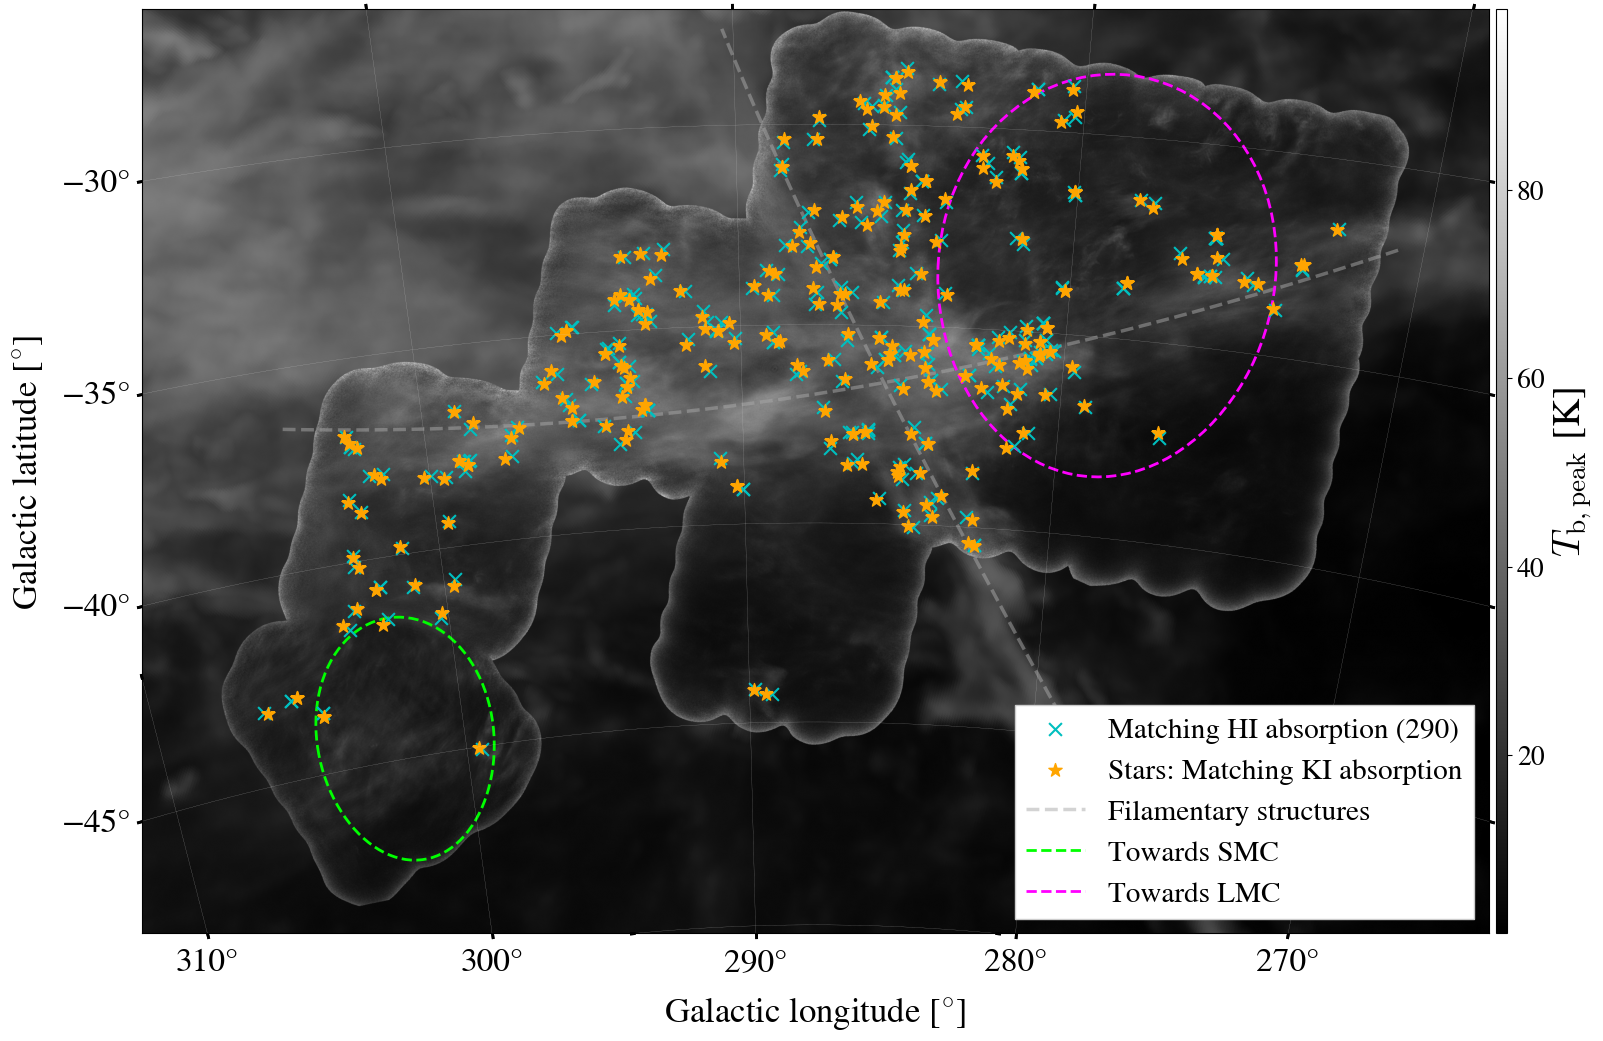

In [ ]:
# Plot
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection=w)

# Display the moment map image
im = ax.imshow(tbpeak_map, cmap='gray')

ax.scatter(matching_src_glons, matching_src_glats,
           s=85,
           c='c',
           transform=ax.get_transform('galactic'),
           marker='x',
           label=f'Matching HI absorption ({n_matchings})')


ax.scatter(matching_star_glons, matching_star_glats,
           s=100,
           c='orange',
           transform=ax.get_transform('galactic'),
           marker='*',
           label=f'Stars: Matching KI absorption')


ax.plot(ch_xcirc, ch_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.5,
        c='darkgray',
        ls='--',
        zorder=0,
        alpha=0.5,
        label='Filamentary structures'
       )


ax.plot(cv_xcirc, cv_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.5,
        c='darkgray',
        ls='--',
        zorder=0,
        alpha=0.5,
        label=''
       )


# # Approximate locations of LMC, SMC
ax.plot(SMC_xcirc,
        SMC_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.,
        zorder=0,
        color='lime',
        ls='--',
        label='Towards SMC'
       )
ax.plot(LMC_xcirc,
        LMC_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.,
        zorder=0,
        color='fuchsia',
        ls='--',
        label='Towards LMC'
       )



# Add axes labels
ax.set_xlabel("Galactic Longitude [degrees]", fontsize=16)
ax.set_ylabel("Galactic Latitude [degrees]", fontsize=16)


## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', location='right', fraction=0.008, pad=0.005, aspect=85)
cbar.ax.set_ylabel(r'$T_\mathrm{b,peak}$ [K]', rotation=90, labelpad=5., fontsize=28)
cbar.ax.tick_params(labelsize=20)


# Add axes labels
ax.set_xlabel(r'Galactic longitude [$^{\circ}$]', fontsize=25)
ax.set_ylabel(r'Galactic latitude [$^{\circ}$]', fontsize=25)

ax.tick_params(axis='x', labelsize=24, pad=4)
ax.tick_params(axis='y', labelsize=24)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)


ax.legend(loc='lower right', fancybox=False, framealpha=1., labelcolor='k', facecolor='w', fontsize=21)
ax.grid(True, linestyle='--', linewidth=0.15, color='lightgray', zorder=-10)
plt.show()

# End